In [3]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.style.use('ggplot')
sns.set_style('white')

/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [20]:
data_csv = './data2/driving_log.csv'
img_dir = './data2/IMG/'

In [37]:
training_data = pd.read_csv(data_csv)
training_data.head()

,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-P3/data2/IMG/center_2017_07_25_16_37_40_124.jpg,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-P3/data2/IMG/left_2017_07_25_16_37_40_124.jpg,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-P3/data2/IMG/right_2017_07_25_16_37_40_124.jpg,0,0.1,0.2,5.771251E-06
0,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-...,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-...,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-...,0.0,0.0,0,0.000095
1,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-...,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-...,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-...,0.0,0.0,0,0.000108
2,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-...,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-...,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-...,0.0,0.0,0,0.000124
3,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-...,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-...,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-...,0.0,0.0,0,0.000141
4,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-...,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-...,/home/rtvdnn/Classes/CarND-Behavioral-Cloning-...,0.0,0.0,0,0.000159


In [38]:
training_data.center[0].split('/')[-1]

AttributeError: 'DataFrame' object has no attribute 'center'

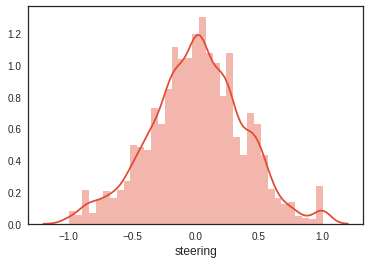

In [36]:
sns.distplot(training_data.steering)

In [10]:
training_data.steering[lambda x: abs(x) < .08].shape[0]  /training_data.steering.shape[0]

0.19166666666666668

# we can see than steering is strongly skewed. 70% inside abs=.08 range.

(160, 320, 3)


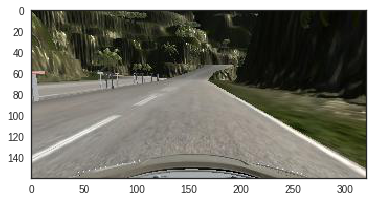

In [21]:
image = plt.imread(img_dir + training_data.center[0].split('/')[-1])
plt.imshow(image)
print(image.shape)

In [32]:
plt.imshow(image[65:-20,...])
print(image[65:-20,...].shape)

TypeError: list indices must be integers or slices, not tuple

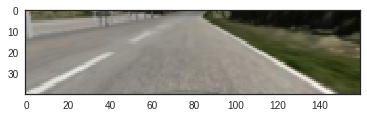

In [24]:
from scipy.misc import imresize
new_image = image[60:-20,...]
plt.imshow(imresize(new_image, (40, 160)))

(15, 85, 320, 3)


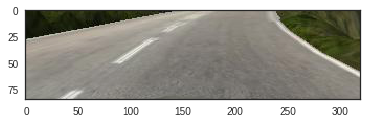

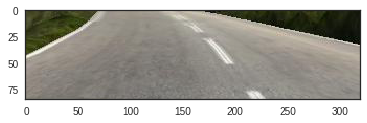

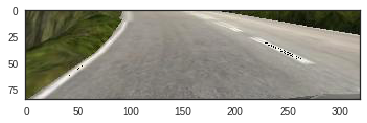

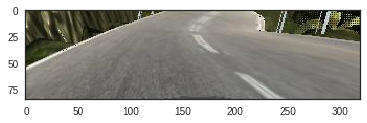

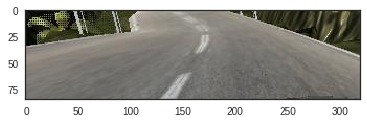

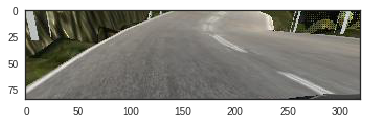

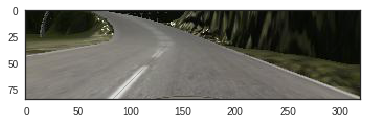

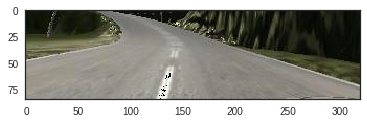

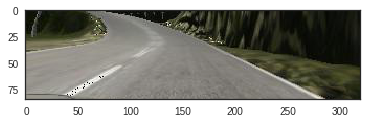

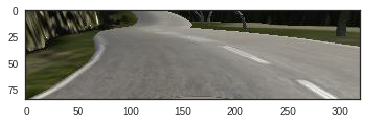

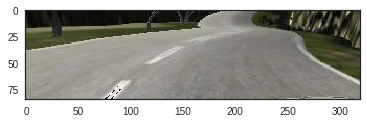

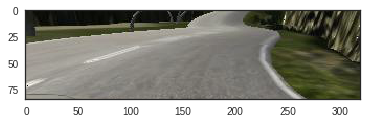

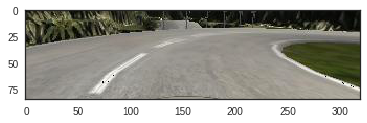

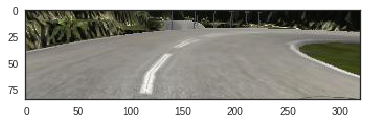

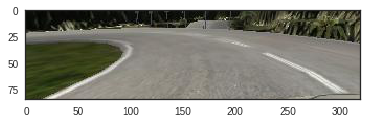

In [35]:
import csv
from sklearn.utils import shuffle
from random import random
lines = []
with open('./data2/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    headers = next(reader, None)
    for line in reader:
        lines.append(line)
lines = shuffle(lines, random_state=1)


def random_brightness(image):
    image1 = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    random_bright = 1.0 + 0.1 * (2 * np.random.uniform() - 1.0)
    image1[:, :, 2] = image1[:, :, 2] * random_bright
    image1 = cv2.cvtColor(image1, cv2.COLOR_HSV2RGB)
    return image1


def random_shear(image, steering, shear_range):
    rows, cols, ch = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    #    print('dx',dx)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 10.0
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
    steering += dsteering

    return image, steering


def generate(ls):
    '''
    Custom image generator. 
    1. Undersample close-to 0 steering data randomly to 20% for balanced data set.
    2. Add left, right images with small adjustment to steering angle
    3. Add flipped image to balance right/left turns
    5. Apply random brightness
    4. Resize images
    :param ls: lines (center, left, right, steer, ...)
    :return: modified images and measurements
    '''
    images = []
    measurements = []
    cam_correction = .05
    correction = [0, cam_correction, -cam_correction]

    for line in ls:
        measurement = float(line[3])
        #if abs(measurement) <= .08 and random() <= .2:
        #    continue
        for i in range(3):
            source_path = line[i]
            filename = source_path.split('/')[-1]
            current_path = './data2/IMG/' + filename
            image = cv2.imread(current_path)
            #image = cv2.resize(image, (160, 40), cv2.INTER_AREA)
            image = random_brightness(image)
            steer = measurement + correction[i]

            #image, steering = random_shear(image, measurement, shear_range=80)
            image = image[60:-20, ...]
            
            if random() > .5:
                images.append(image)
                measurements.append(steer)
            else:
                images.append(cv2.flip(image, 1))
                measurements.append(-steer)
    return images, measurements
image, _ = generate(lines[0:5])
for im in image:
    fig = plt.figure()
    plt.imshow(im)
print(np.array(image).shape)